In [1]:
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import griddata
import pandas as pd
from scipy import optimize
import math
from matplotlib.patches import Polygon

from RoutePlanner.Mesh import Mesh
from RoutePlanner.Plot import PlotMesh, WayPointPaths, PlotRegionPath
from RoutePlanner.Optimisation import TravelTime

In [2]:
IceExtent = {}
IceExtent['X']      = np.load('./resources/IceContent_X.npy') 
IceExtent['Y']      = np.load('./resources/IceContent_Y.npy') 
IceExtent['Values'] = np.load('./resources/IceContent_V.npy') 
IceExtent['Mask']   = np.load('./resources/IceContent_mask.npy') 
vls = IceExtent['Values']
vls[IceExtent['Mask']] = 1.0
IceExtent['Values'] = vls


Coastline = {}
Coastline['X']      = np.load('./resources/IceContent_X.npy') 
Coastline['Y']      = np.load('./resources/IceContent_Y.npy')
values = np.load('./resources/IceContent_V.npy'); values[values < 1] = 0
Coastline['Values'] = values

Currents = {}
Currents['X']  =  np.load('./resources/Current_X.npy') 
Currents['Y']  =  np.load('./resources/Current_Y.npy') 
Currents['Vx'] = np.load('./resources/Current_Vx.npy')
Currents['Vy'] = np.load('./resources/Current_Vy.npy')

In [3]:
MeshInfo = {}
MeshInfo['Xmin'] = 290
MeshInfo['Xmax'] = 310
MeshInfo['Ymin'] = -70
MeshInfo['Ymax'] = -60
MeshInfo['dx']   = 5
MeshInfo['dy']   = 2.5

MeshInfo['CoastMask'] = {}
MeshInfo['CoastMask']['X']          = Coastline['X'] 
MeshInfo['CoastMask']['Y']          = Coastline['Y'] 
MeshInfo['CoastMask']['Mask']       = Coastline['Values'].astype(bool)
MeshInfo['CoastMask']['Split']      = True
MeshInfo['CoastMask']['SplitDepth'] = 3

MeshInfo['IceExtent'] = {}
MeshInfo['IceExtent']['X']          = IceExtent['X'] 
MeshInfo['IceExtent']['Y']          = IceExtent['Y'] 
MeshInfo['IceExtent']['Values']     = IceExtent['Values']
MeshInfo['IceExtent']['Mask']       = IceExtent['Mask']
MeshInfo['IceExtent']['Split']      = True 
MeshInfo['IceExtent']['SplitDepth'] = 3
MeshInfo['IceExtent']['SplitDiff']  = 0.1
MeshInfo['IceExtent']['MaxProportion'] = 0.8

MeshInfo['Currents'] = {}
MeshInfo['Currents']['X']  = Currents['X'] 
MeshInfo['Currents']['Y']  = Currents['Y']
MeshInfo['Currents']['Vx'] = Currents['Vx'] 
MeshInfo['Currents']['Vy'] = Currents['Vy'] 




### Generating Mesh from Land & Ice Content

In [4]:
mesh = Mesh(MeshInfo)
mesh.IceInformation()
mesh.VectorInformation()


=============== Initialising Mesh ================
Xmin=290,Xmax=310,dX=5  Ymin=-70,Ymax=-60,dY=2.5

============ GRIDDING LAND INFORMATION ===========
~~~~~~~~ Initialising Original Mask Array ~~~~~~~~
~~~~~~~~ Splitting Mask array based on Coast ~~~~~~~~
-----> Max Depth=3

============ GRIDDING ICE INFORMATION ===========
~~~~~~~~ Initialising Original Mask Array ~~~~~~~~
~~~~~~~~  Splitting Mask array based on Ice Content ~~~~~~~~
-----> Max Depth=3

============ GRIDDING Current Data ===============


c:\Users\jonsmi\OneDrive - NERC\Documents\BAS_RoutePlanner\SDADT-pyRoutePlanner\RoutePlanner\Mesh.py:137: RuntimeWarning: Mean of empty slice
  self.cells[cc].vector = np.array([np.nanmean(gVx),np.nanmean(gVy)])


### Plotting Generated Mesh

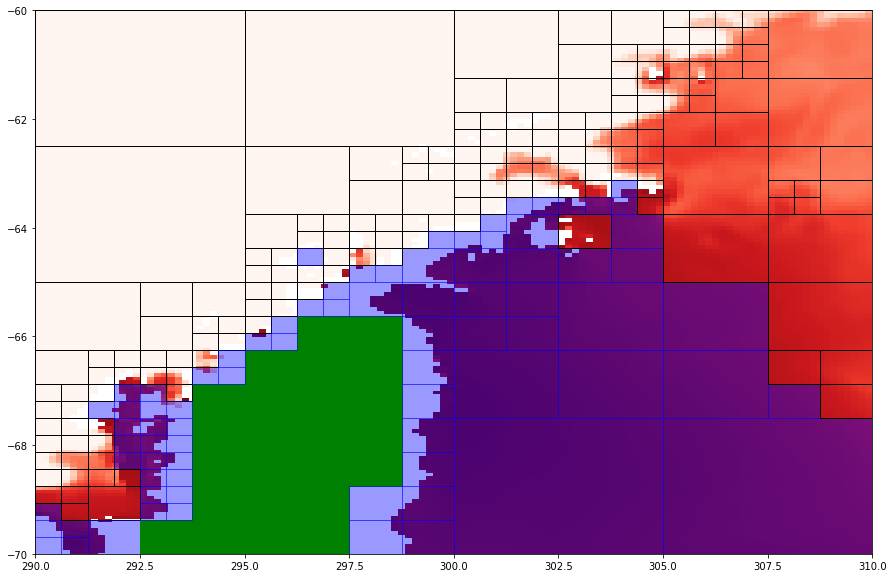

In [5]:
PlotMesh(mesh)


# Optimisation

In [6]:
OptInfo = {}
OptInfo['WayPoints']            = pd.read_csv('./resources/WayPoints_Test.csv') 
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3

In [7]:
TT = TravelTime(mesh,OptInfo)

C:\Users\jonsmi\Miniconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
TT.optimize(verbrose=True)

=== Processing Waypoint = WP1 ===
=== Processing Waypoint = WP3 ===


In [9]:
def OptimisedPaths(ms,optimizer):
    from matplotlib.patches import Polygon
    fig,ax = plt.subplots(1,1,figsize=(15,10))
    fig.patch.set_facecolor('white')

    vls = ms.meshinfo['IceExtent']['Values']
    vls[ms.meshinfo['IceExtent']['Mask']] = np.nan
    ax.pcolormesh(ms.meshinfo['IceExtent']['X'],ms.meshinfo['IceExtent']['Y'],vls,cmap='Reds',vmin=0,vmax=1.0)


    Vals = []
    for cell in ms.cells:
        Bounds = [[cell.x,cell.y],
                            [cell.x,cell.y+cell.dy],
                            [cell.x+cell.dx,cell.y+cell.dy],
                            [cell.x+cell.dx,cell.y],
                            [cell.x,cell.y]]
        if cell.isLand:
            ax.add_patch(Polygon(Bounds, closed=True,
                            fill=True,color='Green',edgecolor='Gray'))
        elif cell.value > ms.meshinfo['IceExtent']['MaxProportion']:
            #ax.quiver(cell.cx,cell.cy,cell.vector[0],cell.vector[1])
            ax.add_patch(Polygon(Bounds, closed=True, fill= True, color='Blue',alpha=0.4))

        else:
            ax.add_patch(Polygon(Bounds, closed=True,fill=False,edgecolor='Gray'))
            #ax.quiver(cell.cx,cell.cy,cell.vector[0],cell.vector[1])

    ax.set_xlim([ms.meshinfo['Xmin'],ms.meshinfo['Xmax']])
    ax.set_ylim([ms.meshinfo['Ymin'],ms.meshinfo['Ymax']])


    # Constructing the cell paths information
    for indx in range(len(optimizer.Paths['Path'])):
        Points = np.array(optimizer.Paths['Path'][indx])
        ax.plot(Points[:,0],Points[:,1],linewidth=1.0,color='k')
        ax.scatter(Points[:,0],Points[:,1],15,marker='o',color='k')

    ax.scatter(optimizer.OptInfo['WayPoints']['Long'],optimizer.OptInfo['WayPoints']['Lat'],100,marker='^',color='b')



C:\Users\jonsmi\AppData\Local\Temp/ipykernel_15100/1877302173.py:19: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Polygon(Bounds, closed=True,


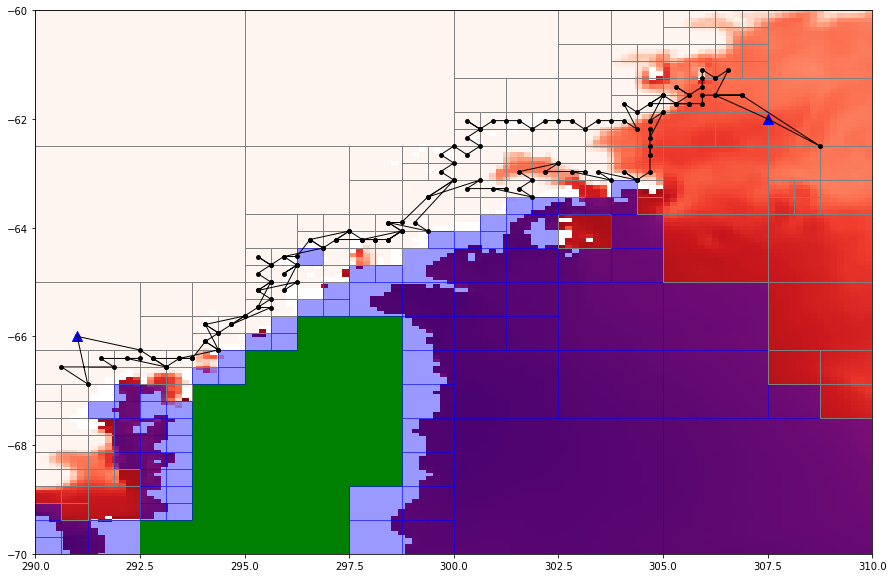

In [10]:
OptimisedPaths(mesh,TT)